# Baseline Model Development

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score

import statsmodels.api as sm

from imblearn.over_sampling import SMOTE


%matplotlib inline

Using TensorFlow backend.


In [114]:
def confusion_reporting(true_values, pred_values):
    '''
    This function takes in the true values of a dataset and the predicted values
    of the dataset and prints out a classification report, accuracy score, and
    plots the confusion matrix of the true and predicted values for simple analysis
    '''
    print(confusion_matrix(true_values, pred_values))
    print(classification_report(true_values, pred_values))
    print('Accuracy score:', round(accuracy_score(true_values, pred_values), 4))

    cm = confusion_matrix(true_values, pred_values)
    df_cm = pd.DataFrame(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],
                         index=['F', 'T'],
                         columns=['F', 'T'])
    plt.figure(figsize=(7, 5))
    sns.heatmap(df_cm, annot=True, cmap='Greens', vmin=0, vmax=1)
    plt.xlabel('Pred Val')
    plt.ylabel('True Val')
    plt.show()

In [52]:
main_df = pd.read_pickle('main_df.pkl')

display(main_df.head())
display(main_df.info())

,congress,chamber,rollnumber,icpsr,cast_code,state_abbrev,bioname,bioguide_id,born,nominate_dim1,...,cosponsor_my_party,cosponsors^2,cosponsors_D^2,cosponsors_R^2,cosponsors_ID^2,cosponsor_my_party^2,party_D,sponsor_party_D,party_R,sponsor_party_R
5,113,Senate,1,14009,1,MS,"COCHRAN, William Thad",C000567,1937,0.287,...,1,4.0,1,1,0,1,0,1,1,0
12,113,Senate,1,14203,1,MT,"BAUCUS, Max Sieben",B000243,1941,-0.212,...,1,4.0,1,1,0,1,1,1,0,0
18,113,Senate,1,14226,1,IA,"GRASSLEY, Charles Ernest",G000386,1933,0.346,...,1,4.0,1,1,0,1,0,1,1,0
24,113,Senate,1,14230,1,IA,"HARKIN, Thomas Richard (Tom)",H000206,1939,-0.351,...,1,4.0,1,1,0,1,1,1,0,0
30,113,Senate,1,14307,1,VT,"LEAHY, Patrick Joseph",L000174,1940,-0.361,...,1,4.0,1,1,0,1,1,1,0,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 102692 entries, 5 to 306260
Data columns (total 78 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   congress                       102692 non-null  int64  
 1   chamber                        102692 non-null  object 
 2   rollnumber                     102692 non-null  int64  
 3   icpsr                          102692 non-null  int64  
 4   cast_code                      102692 non-null  int64  
 5   state_abbrev                   102692 non-null  object 
 6   bioname                        102692 non-null  object 
 7   bioguide_id                    102692 non-null  object 
 8   born                           102692 non-null  int64  
 9   nominate_dim1                  102692 non-null  float64
 10  nominate_dim2                  102692 non-null  float64
 11  party                          102692 non-null  object 
 12  last_name                     

None

#### Drop all roll numbers excepts last for each bill

In [53]:
last_roll_per_bill = main_df.groupby(['congress', 'bill_number']).rollnumber.max().reset_index()
last_roll_per_bill.columns = ['congress', 'bill_number', 'last_rollcall']
main_df_last_roll = main_df.merge(last_roll_per_bill, how='left', on=['congress', 'bill_number'])

main_df = main_df_last_roll[main_df_last_roll['rollnumber'] == main_df_last_roll['last_rollcall']]

In [54]:
dep_col = 'cast_code'

senator_info = ['nominate_dim1', 'nominate_dim2', 'percent_campaign_vote', 'election_year', 'tenure', 
                'age', 'is_sponsor', 'sponsor_is_same_party', 'party_D', 'party_R', 'cosponsor_my_party', 
                'cosponsor_my_party^2']

bill_info = ['sponsor_party_is_lead', 'cosponsor_party_D_%', 'cosponsor_party_R_%', 
             'percent_cosponsors_lead_party', 'lead_party_D', 'sponsor_party_D', 'sponsor_party_R',
             'cosponsors', 'cosponsors_D', 'cosponsors_R', 'cosponsors_ID',
             'cosponsors^2', 'cosponsors_D^2', 'cosponsors_R^2', 'cosponsors_ID^2']

indep_cols = senator_info + bill_info

In [115]:
scalar = StandardScaler()

In [116]:
y = main_df[dep_col]
X = main_df[indep_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

# X_train_df = pd.DataFrame(X_train, index=y_train.index, columns=X.columns)
X_test_df = pd.DataFrame(X_test, index=y_test.index, columns=X.columns)

In [117]:
os = SMOTE(random_state=0)
columns = X.columns
os_data_X, os_data_y = os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=columns )
# os_data_y = pd.DataFrame(data=os_data_y, columns=['cast_code'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of nay cast codes in oversampled data:", len(os_data_y[os_data_y == 0]))
print("Number of yea cast codes in oversampled data:", len(os_data_y[os_data_y == 1]))
print("Proportion of nay in oversampled data is:", len(os_data_y[os_data_y == 0])/len(os_data_X))
print("Proportion of yea in oversampled data is:", len(os_data_y[os_data_y == 1])/len(os_data_X))

length of oversampled data is  23026
Number of nay cast codes in oversampled data: 11513
Number of yea cast codes in oversampled data: 11513
Proportion of nay in oversampled data is: 0.5
Proportion of yea in oversampled data is: 0.5


In [118]:
logreg = LogisticRegression()
rfe = RFE(logreg, 15)
rfe = rfe.fit(os_data_X, os_data_y.values)

print(rfe.ranking_)

low_rank_features = []
for i in range(len(os_data_X.columns)):
    if rfe.ranking_[i] != 1:
        low_rank_features.append(os_data_X.columns[i])
        
print('Low ranked features: ', low_rank_features)

[ 1  6  9  8 10 11 13  1  1  1  1  1  7  1  2  3 12  4  5  1  1  1  1  1
  1  1  1]
Low ranked features:  ['nominate_dim2', 'percent_campaign_vote', 'election_year', 'tenure', 'age', 'is_sponsor', 'sponsor_party_is_lead', 'cosponsor_party_R_%', 'percent_cosponsors_lead_party', 'lead_party_D', 'sponsor_party_D', 'sponsor_party_R']


In [119]:
cols_to_drop = low_rank_features

new_indep_cols = [x for x in indep_cols if x not in cols_to_drop]

os_data_X = os_data_X[new_indep_cols]
X_test_df = X_test_df[new_indep_cols]

In [120]:
logit_model=sm.Logit(os_data_y, os_data_X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.548493
         Iterations 8
                             Results: Logit
Model:                  Logit              Pseudo R-squared:   0.209     
Dependent Variable:     cast_code          AIC:                25289.2029
Date:                   2020-05-28 16:02   BIC:                25409.8686
No. Observations:       23026              Log-Likelihood:     -12630.   
Df Model:               14                 LL-Null:            -15960.   
Df Residuals:           23011              LLR p-value:        0.0000    
Converged:              1.0000             Scale:              1.0000    
No. Iterations:         8.0000                                           
-------------------------------------------------------------------------
                       Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
-------------------------------------------------------------------------
nominate_dim1          -0.3096   0.0445 

In [121]:
logreg = LogisticRegression()
logreg.fit(os_data_X, os_data_y)
y_pred = logreg.predict(X_test_df)

[[1497  555]
 [1322 3594]]
              precision    recall  f1-score   support

           0       0.53      0.73      0.61      2052
           1       0.87      0.73      0.79      4916

    accuracy                           0.73      6968
   macro avg       0.70      0.73      0.70      6968
weighted avg       0.77      0.73      0.74      6968

Accuracy score: 0.7306


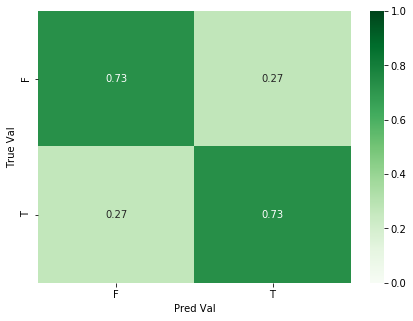

In [122]:
confusion_reporting(y_test, y_pred)

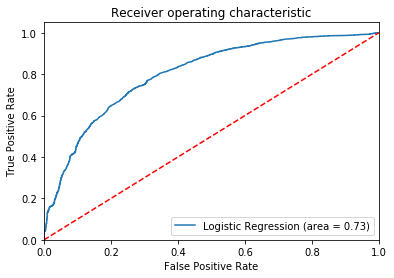

In [123]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test_df))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test_df)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Random Forest

In [124]:
rf_clf = RandomForestClassifier()

In [125]:
scalar = StandardScaler()

In [126]:
y = main_df[dep_col]
X = main_df[indep_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

# X_train_df = pd.DataFrame(X_train, index=y_train.index, columns=X.columns)
# X_test_df = pd.DataFrame(X_test, index=y_test.index, columns=X.columns)

In [127]:
os = SMOTE(random_state=0)
columns = X.columns
os_data_X, os_data_y = os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)

In [128]:
rf_clf.fit(os_data_X, os_data_y)
y_pred = rf_clf.predict(X_test)

[[1453  599]
 [ 610 4306]]
              precision    recall  f1-score   support

           0       0.70      0.71      0.71      2052
           1       0.88      0.88      0.88      4916

    accuracy                           0.83      6968
   macro avg       0.79      0.79      0.79      6968
weighted avg       0.83      0.83      0.83      6968

Accuracy score: 0.8265


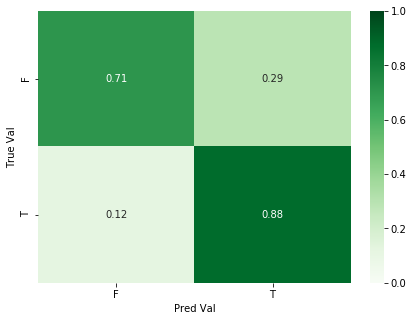

In [129]:
confusion_reporting(y_test, y_pred)

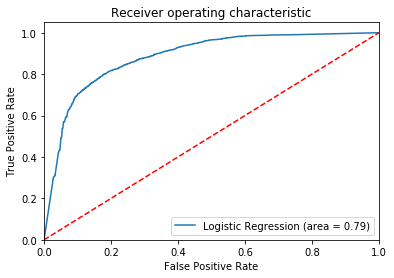

In [130]:
rf_roc_auc = roc_auc_score(y_test, rf_clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf_clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [131]:
feat_imp = pd.DataFrame({'feature': list(X.columns),
                         'importance': rf_clf.feature_importances_}).sort_values('importance', ascending = False)

feat_imp = feat_imp.reset_index(drop=True)

feat_imp

,feature,importance
0,nominate_dim1,0.093341
1,cosponsor_my_party,0.086499
2,sponsor_is_same_party,0.080930
3,age,0.072700
4,tenure,0.069290
5,cosponsor_my_party^2,0.063578
6,nominate_dim2,0.059127
7,percent_campaign_vote,0.053291
8,cosponsors,0.045376
9,cosponsors^2,0.043780


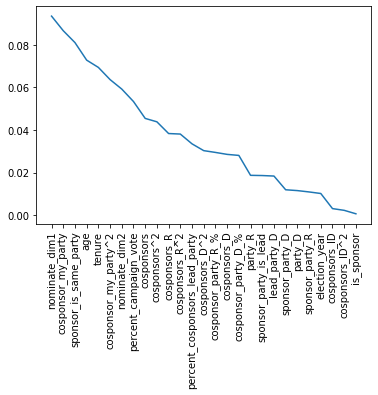

In [132]:
plt.plot(feat_imp['feature'], feat_imp['importance'])
plt.xticks(rotation=90)
plt.show()

## Using Feature Importance from RF to tailor Logit

In [133]:
scorecard = []
for i in range(1, len(feat_imp)+1):
    y = main_df[dep_col]
    X = main_df[feat_imp['feature'].iloc[:i].values]

    scalar = StandardScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    X_train = scalar.fit_transform(X_train)
    X_test = scalar.transform(X_test)

#     X_train_df = pd.DataFrame(X_train, index=y_train.index, columns=X.columns)
#     X_test_df = pd.DataFrame(X_test, index=y_test.index, columns=X.columns)
    
    os = SMOTE(random_state=0)
    columns = X.columns
    os_data_X, os_data_y = os.fit_sample(X_train, y_train)
    os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
    
    logreg = LogisticRegression()
    logreg.fit(os_data_X, os_data_y)
    y_pred = logreg.predict(X_test)
    
    score = accuracy_score(y_test, y_pred)
    
    scorecard.append({'num_features': i, 'score': score})
    
scorecard

/Users/flatironschool/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/flatironschool/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

[{'num_features': 1, 'score': 0.4998564867967853},
 {'num_features': 2, 'score': 0.5355912743972445},
 {'num_features': 3, 'score': 0.6884328358208955},
 {'num_features': 4, 'score': 0.6884328358208955},
 {'num_features': 5, 'score': 0.6897244546498278},
 {'num_features': 6, 'score': 0.7062284730195177},
 {'num_features': 7, 'score': 0.7042192881745121},
 {'num_features': 8, 'score': 0.7053673938002296},
 {'num_features': 9, 'score': 0.7101033295063146},
 {'num_features': 10, 'score': 0.7082376578645235},
 {'num_features': 11, 'score': 0.7099598163030999},
 {'num_features': 12, 'score': 0.7111079219288174},
 {'num_features': 13, 'score': 0.7112514351320322},
 {'num_features': 14, 'score': 0.710820895522388},
 {'num_features': 15, 'score': 0.7116819747416763},
 {'num_features': 16, 'score': 0.7115384615384616},
 {'num_features': 17, 'score': 0.7290470723306545},
 {'num_features': 18, 'score': 0.7304822043628014},
 {'num_features': 19, 'score': 0.7271814006888634},
 {'num_features': 20, 

[[1516  536]
 [1342 3574]]
              precision    recall  f1-score   support

           0       0.53      0.74      0.62      2052
           1       0.87      0.73      0.79      4916

    accuracy                           0.73      6968
   macro avg       0.70      0.73      0.70      6968
weighted avg       0.77      0.73      0.74      6968

Accuracy score: 0.7305


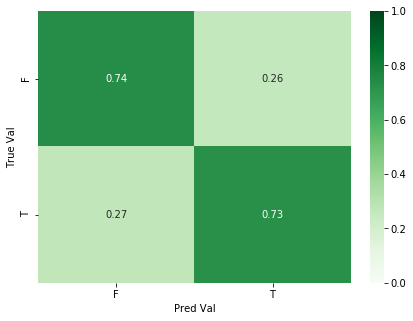

In [137]:
y = main_df[dep_col]
X = main_df[feat_imp['feature'].iloc[:18].values]

scalar = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

# X_train_df = pd.DataFrame(X_train, index=y_train.index, columns=X.columns)
# X_test_df = pd.DataFrame(X_test, index=y_test.index, columns=X.columns)

os = SMOTE(random_state=0)
columns = X.columns
os_data_X, os_data_y = os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)

logreg = LogisticRegression()
logreg.fit(os_data_X, os_data_y)
y_pred = logreg.predict(X_test)

confusion_reporting(y_test, y_pred)

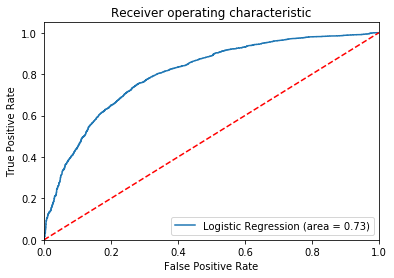

In [139]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()